In [1]:
import tensorflow as tf

In [2]:
from PIL.Image import open
from numpy import array, float32, reshape

In [3]:
from watermarking import training

In [4]:
from re import sub, search
from os import listdir
from numpy import expand_dims, uint8, mean, asarray, flip
from watermarking import embedding, process, extraction, cnn

<h3>Change Watermark to One-Hot</h3>

In [5]:
def WM_to_one_hot(wm):
    one_hot = []
    for row in wm:
        new_row = []
        for _px in row:
            new_row.append(
                [0, 1] if _px == 0 else [1, 0]
            )
        one_hot.append(new_row)
    return array(one_hot)

def WMs_to_one_hot(wms):
    one_hot_wms = []
    for wm in wms:
        one_hot_wms.append(WM_to_one_hot(wm))
    return array(one_hot_wms)

In [6]:
train = training.Training()

initializing
enc   0  ->  64
dec   0  ->  64


In [7]:
attacked_watermarks = WMs_to_one_hot(
    train.normalize_watermark(
        train.apply_transformations(
            open("Watermark.tiff"), iswatermark=True
        )
    )
)


In [8]:
test = train.normalize_watermark(
    train.apply_transformations(
        open("Watermark.tiff"), iswatermark=True
    )
)

In [9]:
watermark = open("Watermark.tiff")

<h3>Load Training Images</h3>

In [10]:
def create_train_label(wms, total_img):
    train_label = []
    attack_i = 0
    for i in range(total_img):
        train_label.append(wms[0])
        attack_i += 1
        if attack_i == 24:
            attack_i = 0
    return array(train_label)

In [11]:
training_images_filename = listdir(train.PRE_TRAINING_PATH)
train_imgs = []
for filename in training_images_filename:
    image = open(train.PRE_TRAINING_PATH + "/" + filename)
    full_path = train.TRAINING_PATH + "/" + sub(
       search(".tif+$", filename).group(), "", filename
    )
    embedding.Embedding().embed_watermark(
        process.Process.pil_to_open_cv(
            image
        ),
        array(watermark, dtype=uint8),
        full_path
    )
    image = open(full_path + ".tif")
    train_imgs.extend(
        expand_dims(
            train.normalize_embedding_maps(
                train.get_embedding_maps(                   
                    train.apply_transformations(image),
                    extraction.Extraction().extract_key_from_pil_image(image)
                )
            ), axis=3
        )
    )

total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24


In [12]:
train_imgs = array(train_imgs)

In [13]:
train_imgs.shape

(960, 64, 64, 1)

In [14]:
train_label = create_train_label(attacked_watermarks, train_imgs.shape[0])

<h3>Model</h3>

In [ ]:
def compute_nc(inputs):
    labels = inputs[0]
    preds = inputs[1]
    
    summed = []
    for i, pred in enumerate(preds):
        summed.append(
            extraction.Extraction.normalized_correlation_coef(
                labels[i], pred
            )
        )
    print('\n', summed)
    return mean(summed, axis=0)

@tf.function 
def tf_function(input): 
    return tf.numpy_function(compute_nc, [input], tf.float32) 

class normalized_correlation_coef(tf.keras.metrics.Metric):
    def __init__(self, name="normalized correlation", **kwargs):
        super(normalized_correlation_coef, self).__init__(name=name, **kwargs)
        self.true_positives = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives = tf_function([y_true, y_pred])

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives = 0.0

In [15]:
model = tf.keras.Sequential([
    # encoder
    tf.keras.layers.Conv2D(
        8, 7, input_shape=(64, 64, 1), activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        8, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    # decoder
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(
        1, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        1, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        2, 7, activation = 'softmax', padding= 'same', kernel_initializer = 'random_normal', use_bias=False
    )
])

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         3136      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 1)         392       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 1)         49        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 2)         9

In [17]:
history = model.fit(
    train_imgs,
    train_label,
    epochs=100,
    batch_size=24,
    verbose=0
)

In [18]:
history.history['accuracy']

[0.5428665280342102,
 0.6634287238121033,
 0.6946736574172974,
 0.6839945316314697,
 0.7067098021507263,
 0.7014803290367126,
 0.7156936526298523,
 0.714441180229187,
 0.724029004573822,
 0.7238283753395081,
 0.7328852415084839,
 0.7313776612281799,
 0.7331336736679077,
 0.7392603754997253,
 0.7365443110466003,
 0.7427161931991577,
 0.7424555420875549,
 0.7454500794410706,
 0.7452547550201416,
 0.7474851012229919,
 0.7485128045082092,
 0.7518582940101624,
 0.7529919743537903,
 0.7553126215934753,
 0.7560099363327026,
 0.7576871514320374,
 0.7591890692710876,
 0.758391797542572,
 0.7636772394180298,
 0.7638389468193054,
 0.7631917595863342,
 0.7671157717704773,
 0.7675519585609436,
 0.7691774964332581,
 0.771320104598999,
 0.771057665348053,
 0.7714144587516785,
 0.7730705142021179,
 0.7747166752815247,
 0.7761512994766235,
 0.7763455510139465,
 0.7787986993789673,
 0.7782061100006104,
 0.7794542908668518,
 0.781134307384491,
 0.7787579894065857,
 0.7837560176849365,
 0.7839006781578064

In [19]:
image = open("static/training/bird.tif")

In [20]:
ext = extraction.Extraction()

In [21]:
key = ext.extract_key_from_pil_image(image)

In [22]:
em = expand_dims(ext.get_embedding_map(process.Process.pil_to_open_cv(image), key), axis=2)

In [23]:
result = model.predict(expand_dims(em, axis=0))

In [24]:
classified = []
for row in result[0]:
    new_row = []
    for _px in row:
        new_row.append(
            255 if _px[0] > _px[1] else 0
        )
    classified.append(new_row)

In [25]:
from matplotlib.pyplot import imshow

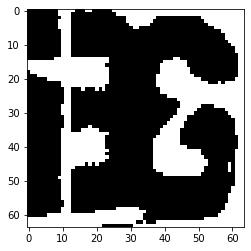

In [26]:
imshow(classified, cmap='gray')

In [27]:
extraction.Extraction.normalized_correlation_coef(classified, watermark)

0.8775974676041001

In [28]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [29]:
layer_dict

{'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1db770f72e0>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1db75605940>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1db75605df0>,
 'up_sampling2d': <tensorflow.python.keras.layers.convolutional.UpSampling2D at 0x1db75605ee0>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1db76f25220>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1db76f256d0>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1db76f25b50>}

<h3>Change Weight Shape</h3>

In [86]:
weight = layer_dict['conv2d_4'].weights

In [87]:
weight = weight[0].numpy()

In [88]:
weight.shape

(7, 7, 1, 2)

In [89]:
weight

array([[[[ 0.16667558, -0.06492028]],

        [[-0.00948727, -0.04323376]],

        [[-0.00360117, -0.01105739]],

        [[ 0.0677385 , -0.02380007]],

        [[ 0.05931535, -0.06758911]],

        [[ 0.03562168,  0.0125448 ]],

        [[ 0.01866768, -0.02216517]]],


       [[[ 0.05082073, -0.03563641]],

        [[-0.04841435,  0.04859838]],

        [[-0.04437268,  0.01844043]],

        [[-0.02433467,  0.09040938]],

        [[ 0.03364938,  0.08507767]],

        [[-0.06487942,  0.05534901]],

        [[-0.09960774,  0.07120173]]],


       [[[ 0.06109047, -0.02329543]],

        [[-0.02063063, -0.03610097]],

        [[-0.01111494,  0.00374368]],

        [[-0.03641557,  0.03624343]],

        [[-0.0042305 , -0.00965132]],

        [[ 0.00252997,  0.05119012]],

        [[-0.12014755,  0.12947462]]],


       [[[ 0.01617598, -0.07287698]],

        [[ 0.02167678,  0.04921418]],

        [[-0.09161509, -0.03317524]],

        [[-0.04317078,  0.10443063]],

        [[-0.114310

In [90]:
def reverse_shape(weight):
    ch_number = weight.shape[3]
    input_number = weight.shape[2]
    new_weight = []
    for i in range(ch_number):
        new_channel = []
        for j in range(input_number):
            new_input = []
            for row in weight:
                new_row = []
                for _px in row:
                    new_row.append(_px[j][i])
                new_input.append(new_row)
            new_channel.append(new_input)
        new_weight.append(new_channel)
    return new_weight

In [91]:
reversed_weight = array(reverse_shape(weight))

In [92]:
def create_param_dict(weight, prefix):
    param = {}
    for i, channel in enumerate(weight):
        for j, matrix in enumerate(channel):
            param[prefix + '-' + str(i) + '-' + str(j)] = matrix
    return param

In [83]:
param_dict = create_param_dict(reversed_weight, 'dec0-0')

In [97]:
reversed_weight = reversed_weight.reshape((2,7,7))
param_dict = {
    'softmax-fg': reversed_weight[1],
    'softmax-bg': reversed_weight[0]
}

In [98]:
param_dict

{'softmax-fg': array([[-0.06492028, -0.04323376, -0.01105739, -0.02380007, -0.06758911,
          0.0125448 , -0.02216517],
        [-0.03563641,  0.04859838,  0.01844043,  0.09040938,  0.08507767,
          0.05534901,  0.07120173],
        [-0.02329543, -0.03610097,  0.00374368,  0.03624343, -0.00965132,
          0.05119012,  0.12947462],
        [-0.07287698,  0.04921418, -0.03317524,  0.10443063,  0.01168326,
          0.06345823,  0.10800921],
        [-0.09973829,  0.06957741,  0.01851835,  0.04670496,  0.07724608,
          0.05154409,  0.07134371],
        [-0.05833729, -0.00969899, -0.0021766 ,  0.07454877, -0.02980711,
         -0.00799724,  0.03522492],
        [-0.16474234, -0.01146568, -0.09127045, -0.12199184, -0.1171454 ,
         -0.09384751, -0.02379504]], dtype=float32),
 'softmax-bg': array([[ 0.16667558, -0.00948727, -0.00360117,  0.0677385 ,  0.05931535,
          0.03562168,  0.01866768],
        [ 0.05082073, -0.04841435, -0.04437268, -0.02433467,  0.03364938,
 

In [99]:
cnn.CNN.store_param(param_dict)

<h3>Get Visualization Model</h3>

In [100]:
outputs = [layer.output for layer in model.layers[1:]]

In [101]:
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

In [102]:
feature_maps = visualization_model.predict(array([train_imgs[0]]))

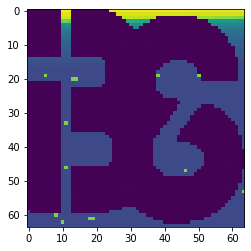

In [218]:
imshow(array(train_imgs[0]).reshape((64, 64)))

In [128]:
def reverse_shape_fm(feature_map):
    ch_number = feature_map.shape[2]
    new_fm = []
    for i in range(ch_number):
        new_channel = []
        for row in feature_map:
            new_row = []
            for _px in row:
                new_row.append(_px[i])
            new_channel.append(new_row)
        new_fm.append(new_channel)
    return new_fm

In [158]:
array(feature_maps[5]).shape

(1, 64, 64, 2)

In [213]:
reversed_fm = reverse_shape_fm(feature_maps[0][0])

In [214]:
from matplotlib.pyplot import figure

In [215]:
array(reversed_fm).shape

(8, 64, 64)

In [219]:
array(reversed_fm)

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., 16.860516  ,
         15.789776  , 41.488266  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 39.503456  ,
         26.030247  , 31.683926  ],
        [ 0.        ,  0.        ,  0.        , ..., 44.99916   ,
         28.992046  , 38.557617  ],
        [ 0.        ,  4.322708  ,  0.        , ..., 44.281235  ,
         28.990574  , 32.0976    ]],

       [[34.381153  , 32.6238    , 24.257019  , ...,  0.        ,
          0.        ,  0.        ],
        [31.895927  , 25.500015  , 12.908596  , ...,  0.        ,
          0.        ,  0.        ],
        [28.292439  , 19.206627  ,  6.757166  , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 9.245382  ,  0.        ,  0.        , ...,  

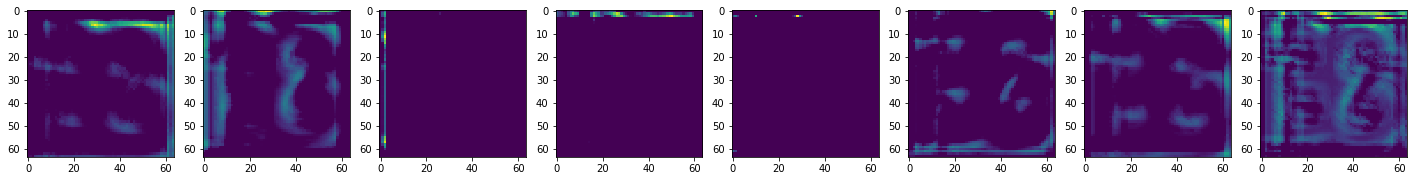

In [185]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

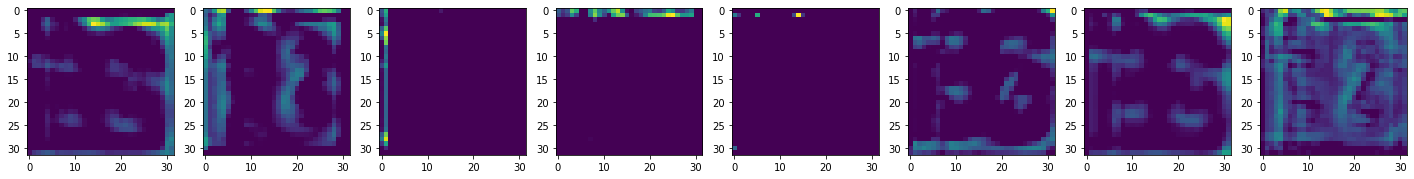

In [189]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

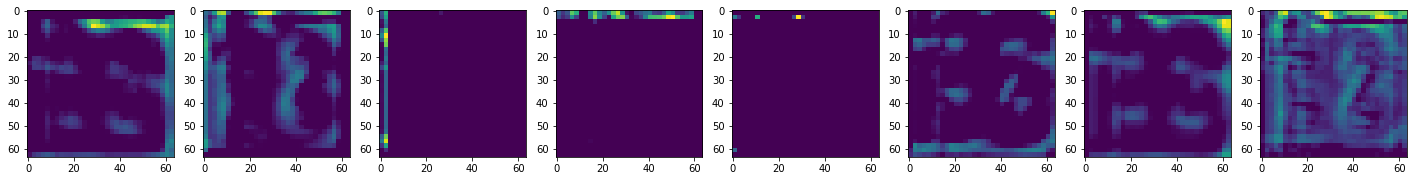

In [193]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

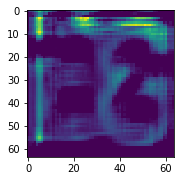

In [197]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

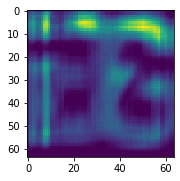

In [201]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

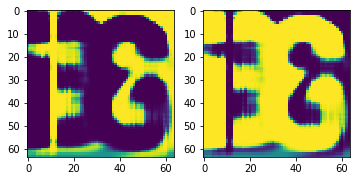

In [205]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [250]:
a = tf.keras.layers.Conv2D(
    8, 7, input_shape=(64, 64, 1), padding = 'same', kernel_initializer=tes, use_bias=False
)(array([train_imgs[0]]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [249]:
def tes(shape, dtype=None):
    w = layer_dict['conv2d'].weights[0].numpy()
#     w[tuple(map(lambda x: int(np.floor(x/2)), w.shape))]=1
    return w

In [255]:
a = a.numpy()

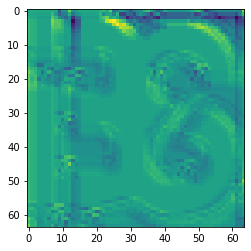

In [260]:
imshow(reverse_shape_fm(a[0])[3])

In [ ]:
a